# DQND

## libraries and data

In [1]:
import sys, os
cwd = os.getcwd()

In [2]:
%%capture
os.chdir(cwd+"/common")
!python3 -m atari_py.import_roms ../Roms
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Algorithm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import gym
import numpy as np

import math, random
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

from model import CnnDQNCrop, ConvDuelingDQN
from buffers import ReplayBuffer
from utils import crop_breakout

/home/zhanghao/.local/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Environment and parameter

In [9]:
seed = 5446
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed_all(seed)

env_id = "Breakout-v4"
env = gym.make(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 300000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 3000000
batch_size = 32
gamma      = 0.99

replay_initial = 100000
replay_buffer = ReplayBuffer(replay_initial)

def get_epsilon(frame_idx):
    if frame_idx >= replay_initial:
        epsilon = epsilon_by_frame(frame_idx-replay_initial)
    else:
        epsilon = 1
    
    return epsilon



### display epsilon over training

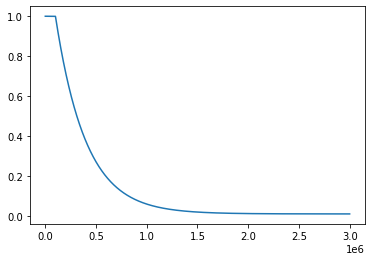

In [11]:
plt.plot([get_epsilon(i) for i in range(num_frames)])

In [12]:
model = ConvDuelingDQN(env.action_space.n)

if torch.cuda.is_available():
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00025,weight_decay=0.05)

# model.load_state_dict(torch.load(cwd+"/models/dqn_breakout_crop.pt"))



### Compute Loss

In [13]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value  * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

### plot function

In [14]:
from utils import moving_average

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Frame: %s Avg.Reward: %s Epsilon: %s' % (frame_idx, np.mean(rewards[-100:]), get_epsilon(frame_idx) ))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('Frame Rewards')
    plt.plot(moving_average(frame_rewards,1000))
    plt.show()

### training

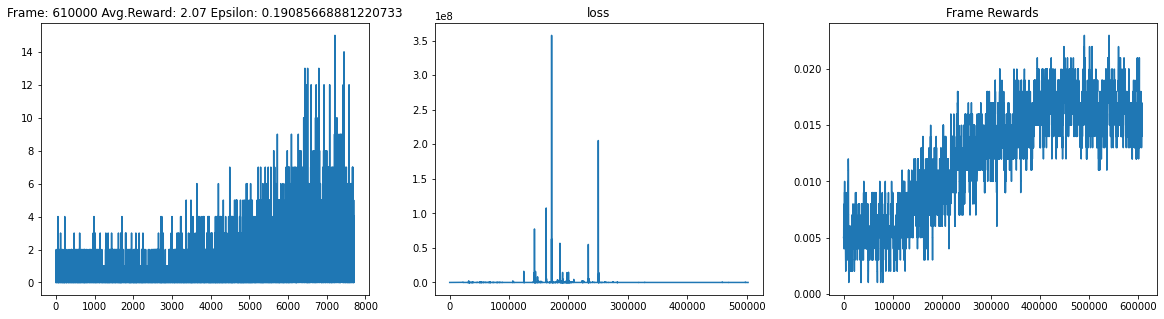

15.0


/home/zhanghao/.local/lib/python3.8/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


In [ ]:
losses = []
all_rewards = []
frame_rewards = []
episode_reward = 0

state = env.reset()
print(state.shape)
# img = plt.imshow(env.render(mode='rgb_array'))

frame_queue = [np.squeeze(np.array(state),axis = 0)]
reward_queue = [0]
for frame_idx in range(1, num_frames + 1):
    
    epsilon = get_epsilon(frame_idx)

    if len(frame_queue)!=4:
        action = random.choice(range(4))
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        frame_queue.append(np.squeeze(np.array(next_state),axis = 0))
        reward_queue.append(episode_reward)
    else:
        state_4frames = np.array([frame_queue[0],frame_queue[1],frame_queue[2],frame_queue[3]])
        if random.random() > epsilon:
            action = model.eval(crop_breakout(state_4frames))
        else:
            action = random.randrange(env.action_space.n)
        
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        reward_4frames = max(reward_queue)
        frame_queue.pop(0)
        reward_queue.pop(0)
        frame_queue.append(np.squeeze(np.array(next_state),axis = 0))
        reward_queue.append(episode_reward)
        next_state_4frames = np.array([frame_queue[0],frame_queue[1],frame_queue[2],frame_queue[3]])
        replay_buffer.push(crop_breakout(state_4frames), action, reward_4frames, crop_breakout(next_state_4frames), done)
        

    state = next_state
    frame_rewards.append(reward)
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        frame_queue = [np.squeeze(np.array(state),axis = 0)]
        reward_queue = [0]
        
        
    if len(replay_buffer) >= replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        print(max(all_rewards))
        
    if frame_idx % 10000 == 0:
        torch.save(model.state_dict(),cwd+"/models/dqnd_breakout_crop.pt")
        np.save(cwd+"/training_data/dqnd_breakout_crop_reward.npy", np.array(all_rewards))
        np.save(cwd+"/training_data/dqnd_breakout_crop_frame_reward.npy", np.array(frame_rewards))
        np.save(cwd+"/training_data/dqnd_breakout_crop_loss.npy", np.array(losses))




### Save Model

In [ ]:
torch.save(model.state_dict(),cwd+"/models/dqnd_breakout_crop.pt")
np.save(cwd+"/training_data/dqnd_breakout_crop_reward.npy", np.array(all_rewards))
np.save(cwd+"/training_data/dqnd_breakout_crop_frame_reward.npy", np.array(frame_rewards))
np.save(cwd+"/training_data/dqnd_breakout_crop_loss.npy", np.array(losses))